In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data cleaning and extract useful data
def GetYearSlice(year,group):
    #This function will return a df that contains data with Year == year-1 and Year == year+1.
    # year: type:int, the year that the policy carries out
    # group: type:str, one string of ["group_ratio_70","group_ratio_80","group_ratio_90"]
    
    df = pd.read_csv("panel.csv")
    
    #Remove the outliers and data with nan
    df = df.loc[(df["region"] != "Tibet")&(df["region"] != "Xinjiang")&(df["region"] != "Ningxia")&(df["region"] != "Shanghai")&(df["region"] != "Beijing")&(df["region"] != "Chongqing")]
    
    # post_pre_year is the dummy var to mark treatment
    df["post_pre_"+str(year)] = 0
    df["post_pre_"+str(year)].loc[(df["Year"] > year)] = 1
    
    # group is the dummy var to mark group
    # inter_year is the interaction term between treatment and group
    df_sliced = df.loc[(df["Year"] == year-1)|(df["Year"] == year+1)]
    df_sliced["inter_"+str(year)]=df_sliced["post_pre_"+str(year)]*df_sliced[group]
    
    return(df_sliced)

In [3]:
# Get T value to test whether two samples have a same mean. H0: Average of a = Average of b.
def GetTValueFrom2Samples(a,b,N):
    # a: type:list, the first list of the two samples
    # b: type:list, the other list of the two samples
    # N: type:int, the size of samples
    
    #list to numpy array
    a=np.asarray(a)
    b=np.asarray(b)
    
    #get variance of a and b
    var_a = a.var(ddof=1)
    var_b = b.var(ddof=1)
    
    #get standard div
    s = np.sqrt((var_a + var_b)/2)
    
    #get t value
    t = (a.mean() - b.mean())/(s*np.sqrt(2/N))
    return t

In [9]:
# Get P value for three models with different methods of grouping
def GetPValues(year):
    # year: type:int, the year that the policy carries out
    
    #train the DiD model 
    #                 total_dic = post_pre_year + group_ratio_70 + inter_year + unemp
    #where post_pre_year is the dummy var for treatment.
    #      group_ratio_70 is the dummy var for group.
    #      inter_year is the interaction term.
    #      unemp is a control var.
    train=GetYearSlice(year,"group_ratio_70")
    model_70 = sm.OLS(train["total_div"], sm.add_constant(train[["post_pre_"+str(year), "group_ratio_70","inter_"+str(year),"unemp"]])).fit()
    
    #train the DiD model 
    #                 total_dic = post_pre_year + group_ratio_80 + inter_year + unemp
    train=GetYearSlice(year,"group_ratio_80")
    model_80 = sm.OLS(train["total_div"], sm.add_constant(train[["post_pre_"+str(year), "group_ratio_80","inter_"+str(year),"unemp"]])).fit()
    
    #train the DiD model 
    #                 total_dic = post_pre_year + group_ratio_90 + inter_year + unemp
    train=GetYearSlice(year,"group_ratio_90")
    model_90 = sm.OLS(train["total_div"], sm.add_constant(train[["post_pre_"+str(year), "group_ratio_90","inter_"+str(year),"unemp"]])).fit()
    
    #return a list containing p values of interaction term with different methods of grouping
    return([model_70.pvalues[3],model_80.pvalues[3],model_90.pvalues[3]])

# Introduction to the Dataset Used in This Practice
This dataset contains spatial panel data of divorce rate, heavy industrial ratio (calculated by heave industry product/population), income level, unemployment rate of each province in China. See the file `panel.csv`.

### Column name and their meanings
<em>total_div</em> <=> divorce rate <br>
<em>ratio_70</em> <=> heavy industrial ratio (calculated by heave industry product/population) of that province in 1970 <br>
<em>ratio_80</em> <=> heavy industrial ratio (calculated by heave industry product/population) of that province in 1980 <br>
<em>ratio_90</em> <=> heavy industrial ratio (calculated by heave industry product/population) of that province in 1990 <br>
<em>group_ratio_70</em> <=> dummy var for heavy industrial ratio in 1970 (0 if below 50% percentile) <br>
<em>group_ratio_80</em> <=> dummy var for heavy industrial ratio in 1980 (0 if below 50% percentile) <br>
<em>group_ratio_90</em> <=> dummy var for heavy industrial ratio in 1990 (0 if below 50% percentile) <br>
<em>unemp</em> <=> unemployment rate of that province

### Intention and the logic behind it
In my previous studies, I found that heavy industrial ratio in 1980s has strong effect on divorce rate in 2000s. But I can't figure out the reason:( <br><br>So in the DiD practice, I grouped provinces into two groups basics on their heavy industrial ratio. "1" means their economy is relatively rich in heavy industry product per capita.<br><br>Now let's say there was an effective policy carried out regarding divorcement and property distribution in year 2005, so that provinces with massive heavy industry will have higher growth rate of <em>total_div</em>.<br><br>This practice will detect the particular year with the significant interaction term and exam the parralel trend hypothesis. 

In [12]:
# Take a glance at the dataset
dataset = pd.read_csv("panel.csv")
dataset.describe()

,Year,total_div,total_div_lastyr,inc,unemp,sex_r,trmt_03,trmt_10,fe_unemp,No_Entp_1980,...,group_ratio_90,total_div_90,waiting_ratio_90,unemp_90,Dummy_Div,group_ratio_80,post_pre_03,inter_03,post_pre_10,inter_10
count,589.000000,589.000000,558.000000,589.000000,587.000000,589.000000,589.000000,589.000000,31.000000,589.000000,...,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000
mean,2006.000000,0.013545,0.013241,26876.956197,3.431652,119.886894,0.644737,0.085837,2.028065,11715.932088,...,0.483871,0.007427,0.015316,0.032006,0.349745,0.483871,0.631579,0.305603,0.263158,0.127334
std,5.481881,0.006935,0.006777,19570.368545,0.838774,367.824229,0.468568,0.277143,1.049760,8473.219056,...,0.500165,0.004943,0.010310,0.007665,0.477295,0.500165,0.482786,0.461054,0.440722,0.333631
min,1997.000000,0.004903,0.004903,4889.000000,0.440000,0.997412,0.000000,0.000000,0.430000,254.000000,...,0.000000,0.003604,0.002171,0.020975,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2001.000000,0.008555,0.008329,10749.000000,3.100000,101.836448,0.000000,0.000000,1.210000,4551.000000,...,0.000000,0.005401,0.007227,0.025897,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2006.000000,0.011557,0.011225,21312.000000,3.500000,103.900000,1.000000,0.000000,1.790000,10540.000000,...,0.000000,0.005881,0.014932,0.030266,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,2011.000000,0.016376,0.015958,39903.000000,4.000000,106.570000,1.000000,0.000000,2.345000,15858.000000,...,1.000000,0.007399,0.020765,0.038525,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,2015.000000,0.039833,0.039833,113073.000000,6.500000,9029.597055,1.000000,1.000000,4.370000,34047.000000,...,1.000000,0.027440,0.049303,0.054697,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


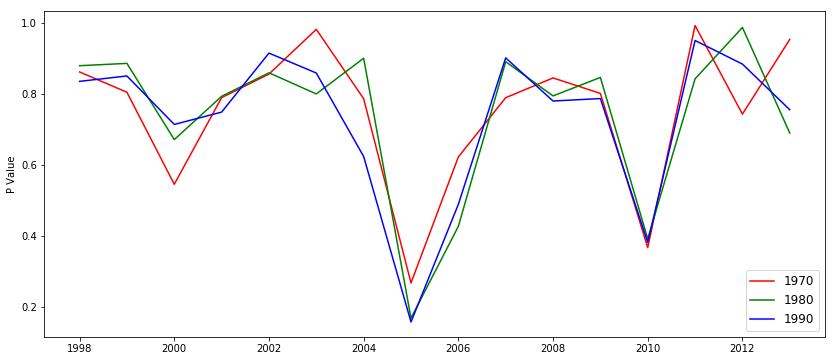

In [5]:
# Sensitivity test: go through different years to find a model that gives out the best p value
data=[]
for year in range(1998,2014):
    data.append({})
    
    #get p_values of different grouping criteria
    p_values=GetPValues(year)
    
    data[len(data)-1]['Year'] = year
    data[len(data)-1]['pvalue_70'] = p_values[0]  
    data[len(data)-1]['pvalue_80'] = p_values[1]
    data[len(data)-1]['pvalue_90'] = p_values[2]

#list to dataframe
df=pd.DataFrame(data)

#plot a graph that
plt.figure(figsize=(14, 6))
plt.plot(df.Year, df.pvalue_70,color='r',label="1970")
plt.plot(df.Year, df.pvalue_80,color='g',label="1980")
plt.plot(df.Year, df.pvalue_90,color='b',label="1990")
plt.legend(loc='lower right', fontsize='large')
plt.ylabel("P Value")
plt.show()

### Comment
In this practice, the interaction term deserves a furthur look when the grouping criteria is <em>group_ratio_1980</em> and the treatment time is 2005. <br><br>So let's check the model for year 2005 with the grouping criteria being <em>group_ratio_80</em>.

In [6]:
# Model summary of the specific model mentioned above
year=2005
group="group_ratio_90"
train=GetYearSlice(year,group)
model = sm.OLS(train["total_div"], sm.add_constant(train[["post_pre_"+str(year), group,"inter_"+str(year),"unemp"]])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              total_div   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     14.72
Date:                Sat, 31 Aug 2019   Prob (F-statistic):           9.21e-08
Time:                        08:14:26   Log-Likelihood:                 217.78
No. Observations:                  50   AIC:                            -425.6
Df Residuals:                      45   BIC:                            -416.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0087      0.003     -2.744      0.009      -0.015      -0.002
post_pre_2005     -0.0004      0.001     -0.317      0.753      -0.003       0.002
group_ratio_90     0.0028      0.001      2.049      0.046     4.7e-05       0.005
inter_2005         0.0027      0.002      1.438      0.157      -0.001       0.007
unemp              0.0046      0.001      5.927      0.000       0.003       0.006
==============================================================================
Omnibus:                        6.543   Durbin-Watson:                   1.332
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                5.444
Skew:                           0.695   Prob(JB):                       0.0657
Kurtosis:                       3.824   Cond. No.                         29.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We notice that when $H_{0}$ is <br>
<center>$\beta_{inter\_2005} < 0$,</center>
P value 0.0785. So $H_{0}$ will be rejeted with 90% confidence level.

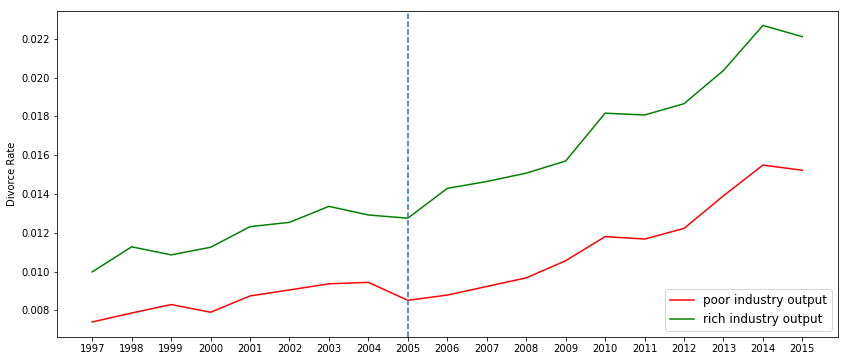

In [7]:
# Plot the average divorce rate of two groups over time
df = pd.read_csv("panel.csv")

#Take out outliers
df = df.loc[(df["region"] != "Tibet")&(df["region"] != "Xinjiang")&(df["region"] != "Ningxia")&(df["region"] != "Shanghai")&(df["region"] != "Beijing")&(df["region"] != "Chongqing")]

#calculate the average divorce rate of each group
df_to_plot = df.groupby(['Year', group], as_index=False).mean()[['Year','total_div',group]]

#plot the graph
df_to_plot.Year=df_to_plot.Year.astype(str)
plt.figure(figsize=(14, 6))
plt.plot(df_to_plot.Year.loc[df_to_plot[group] == 0], df_to_plot.loc[df_to_plot[group] == 0]['total_div'],color='r',label='poor industry output')
plt.plot(df_to_plot.Year.loc[df_to_plot[group] == 1], df_to_plot.loc[df_to_plot[group] == 1]['total_div'],color='g',label='rich industry output')
plt.axvline(x=str(year),linestyle='--')
plt.legend(loc='lower right', fontsize='large')
plt.ylabel("Divorce Rate")
plt.show()

In [8]:
# Exam the parrelel trend assumption
#    Perform a t-test of the difference in average growth rates across the treatment 
#    and control groups during the pre-treatment era. This should turn out insignificant 
#    (statistically andeconomically) if the parallel trends assumption is valid.

#load data
df = pd.read_csv("panel.csv")
df = df.loc[df['Year'] < year]
df = df.loc[(df["region"] != "Tibet")&(df["region"] != "Xinjiang")&(df["region"] != "Ningxia")&(df["region"] != "Shanghai")&(df["region"] != "Beijing")&(df["region"] != "Chongqing")]
df = df.groupby(['Year', group], as_index=False).mean()[['Year','total_div',group]]

#average growth rate before 2005 (treatment=1)
a=df.loc[df[group] == 1].loc[2:,['total_div']]['total_div'].to_list()
b=df.loc[df[group] == 1].loc[:14,['total_div']]['total_div'].to_list()
avg_1=[(a/b-1)*100 for a,b in zip(a,b)]

#average growth rate before 2005 (treatment=0)
a=df.loc[df[group] == 0].loc[2:,['total_div']]['total_div'].to_list()
b=df.loc[df[group] == 0].loc[:14,['total_div']]['total_div'].to_list()
avg_0=[(a/b-1)*100 for a,b in zip(a,b)]

print("T-test =",GetTValueFrom2Samples(avg_1,avg_0,len(avg_0)))

T-test = 0.08971224338861242


The T-test of pre-treatment era shows that <br><br><center>$H_{0}: Average\>divorce\>rate\> growth\> rate\> of\> Group\> 0\> =\> Average\> divorce\> rate\> growth\> rate\> of\> Group\> 1$</center><br>can't be rejected with any proper confidence level.<br>

# Summary
This shows that some policy carries out in 2005 and the policy made provinces with richer industrial product back in 1980s suffer more from divorcement after 2005.